## Install dependencies

In [ ]:
!pip install numpy scipy matplotlib

## Helper functions

In [84]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[], ax=None, **legend_args):
    if ax is None:
        ax = plt.gca()
    
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))   # mu +- 1.96stdev covers 95% of Gaussian dist probabilities
    
    ax.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    ax.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        ax.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        ax.plot(X_train, Y_train, 'rx')
    ax.legend(**legend_args)
    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)




## Define "kernel" function

In [3]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

## Example


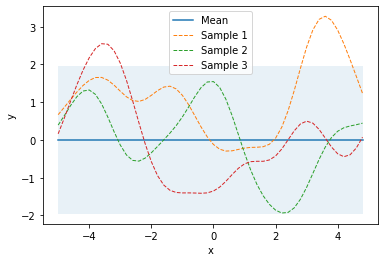

In [65]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

## Function to compute posterior predictive

In [46]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the sufficient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    X_s: New input locations (n x d).
    X_train: Training locations (m x d).
    Y_train: Training targets (m x 1).
    l: Kernel length parameter.
    sigma_f: Kernel vertical variation parameter.
    sigma_y: Noise parameter. Defaults to small value for numerical stability.
    
    Returns posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

## Case of noise-free observation

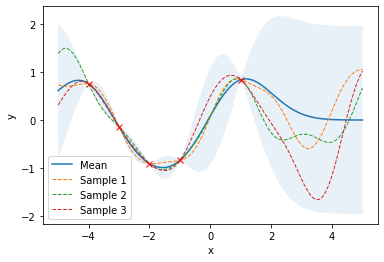

In [131]:
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


### Visualization with "Nice" random samples

array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
        0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ])

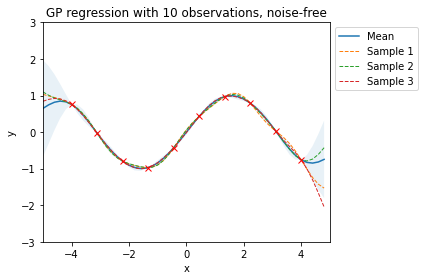

In [150]:
N = 10
x_min, x_max = -4, 4
# x = (x_max - x_min) * np.random.random(N) + x_min    # try explaining what happens when you use this input
x = np.linspace(x_min, x_max, N).reshape(-1, 1)
np.random.shuffle(x)

y_min, y_max = -3, 3    # visualization only
X_train_full = x.reshape(-1, 1)
Y_train_full = np.sin(X_train_full) 
    
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for n in range(N):
    X_train = X_train_full[:(n+1)]
    Y_train = Y_train_full[:(n+1)]
    
    X = np.arange(-5, 5, 0.2).reshape(-1, 1)
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train)
    
    samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
    
    ax = axs
    ax.clear()
    ax.set_xlim(x_min-1, x_max+1)
    ax.set_ylim(y_min, y_max)
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples, ax=ax)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f'GP regression with {n+1} observations, noise-free')

    fig.tight_layout()
    display(fig)

    sleep(1)
    clear_output(wait = True)

In [146]:
X_train.shape

(10, 1)

In [145]:
Y_train.shape

(9, 1)

In [147]:
Y_train_full.shape

(9, 1)

## Case of noisy observation

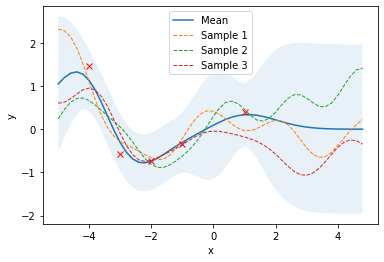

In [151]:
noise = 0.4    # standard deviation of noise term epsilon

# Noisy training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)


### Visualization with random sampling

In [80]:
from time import sleep
from IPython.display import display, clear_output

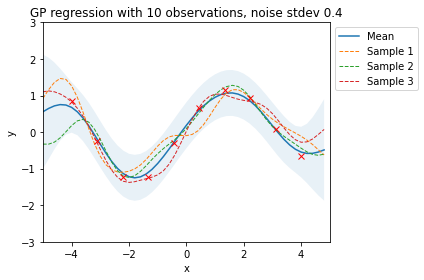

In [155]:
N = 10
x_min, x_max = -4, 4
x = np.linspace(x_min, x_max, N).reshape(-1, 1)
np.random.shuffle(x)

y_min, y_max = -3, 3    # visualization only
noise = 0.4    # standard deviation of noise term epsilon
X_train_full = x.reshape(-1, 1)
Y_train_full = np.sin(X_train_full) + noise * np.random.randn(*X_train_full.shape)
    
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for n in range(N):
    X_train = X_train_full[:(n+1)]
    Y_train = Y_train_full[:(n+1)]
    
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)
    
    samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
    
    ax = axs
    ax.clear()
    ax.set_xlim(x_min-1, x_max+1)
    ax.set_ylim(y_min, y_max)
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples, ax=ax)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f'GP regression with {n+1} observations, noise stdev {noise}')

    fig.tight_layout()
    display(fig)

    sleep(1)
    clear_output(wait = True)

### Visualization, with really random sampling

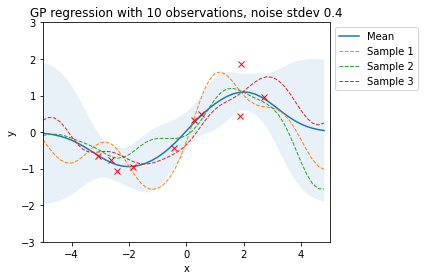

In [157]:
N = 10
x_min, x_max = -4, 4
x = (x_max - x_min) * np.random.random(N) + x_min

y_min, y_max = -3, 3    # visualization only
noise = 0.4    # standard deviation of noise term epsilon
X_train_full = x.reshape(-1, 1)
Y_train_full = np.sin(X_train_full) + noise * np.random.randn(*X_train_full.shape)
    
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for n in range(N):
    X_train = X_train_full[:(n+1)]
    Y_train = Y_train_full[:(n+1)]
    
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)
    
    samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
    
    ax = axs
    ax.clear()
    ax.set_xlim(x_min-1, x_max+1)
    ax.set_ylim(y_min, y_max)
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples, ax=ax)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f'GP regression with {n+1} observations, noise stdev {noise}')

    fig.tight_layout()
    display(fig)

    sleep(1)
    clear_output(wait = True)

## Effect of SE kernel parameters

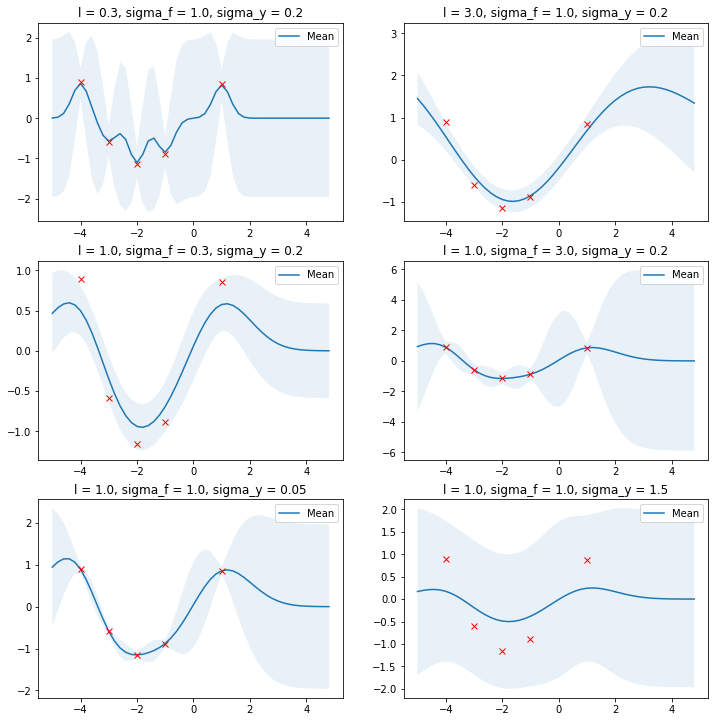

In [50]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

## GP in 2-variable case

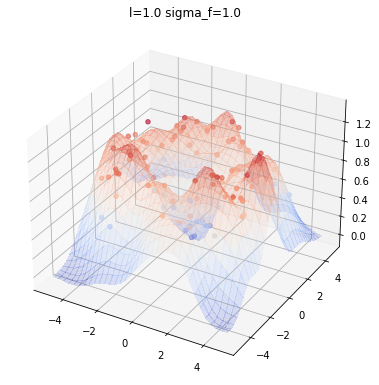

In [51]:
noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior_predictive(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, f'l={1.00} sigma_f={1.00}', 1)
